In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import digamma
from sklearn.gaussian_process import GaussianProcessRegressor


import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install torch==2.0.0
# !pip install gpytorch==1.11

In [3]:
import gpytorch
gpytorch.__version__

'1.11'

In [4]:
import torch
torch.__version__

'2.0.0'

A simple simulation experimental setup:
$$f(x)=x\log x,\;x\in[0,1],\;X|Y=y \sim \textrm{Beta}(\alpha(y),\beta(y)).$$
$f$ has a minimum at $x=1/e$ (no local minima). We can compute
$$g(y)=\mathbb E_{X|Y=y}\left[X\log X\right]=\frac{\alpha(y)}{\alpha(y)+\beta(y)}\left[\psi(\alpha(y)+1)-\psi(\alpha(y)+\beta(y)+1)\right],$$
where $\psi$ is the digamma function. To complete the setup need to choose some functions $\alpha:\mathcal Y\to (0,+\infty)$, $\beta:\mathcal Y\to (0,+\infty),$ e.g. take $\mathcal Y=\mathbb R^3$ and
$$\alpha(y)=\exp(a^\top y+c),\;\beta(y)=\exp(b^\top y+d),$$
or similar.

Nb. the bounded domain of $X$ might need to be built into the kernel construction when estimating CME $X|Y$, e.g. one can use
$$k(x,x')=\exp\left(-\frac{1}{2\gamma^2}\left(\log\frac{x}{1-x}-\log\frac{x'}{1-x'}\right)^2\right),\quad x,x'\in(0,1).$$


In [5]:
def alpha(y,a=1,c=0):
    return np.exp(a * y +c)

def beta(y, b=1, d=0):
    return np.exp(b* y + d)

def func(x):
    return -x * np.log(x)

def g(y,a=1,b=0,c=1,d=0):
    alpha_value = alpha(y,a,c)
    beta_value = beta(y,b,d)
    g_value = alpha_value/(alpha_value+beta_value) * (digamma(alpha_value + 1) - digamma(alpha_value + beta_value + 1))
    return -g_value

In [6]:
def generate_D1(n, a,b,c,d, l, u):
    ys = np.random.uniform(l,u,n)
    alphas = []
    betas = []
    xs = []
    fs = []
    for i in ys:
        alpha_value = alpha(i,a,c)
        alphas.append(alpha_value)
        
        beta_value = beta(i,b,d)
        betas.append(beta_value)
        x_value = np.random.beta(alpha_value, beta_value)
        xs.append(x_value)
    plt.plot(ys, xs, '.')
    plt.xlabel('y')
    plt.ylabel('x')
    plt.title('D1')
    
    plt.legend()
    return np.asarray(xs), np.asarray(ys)
    

def generate_D2(m, a,b,c,d, l, u, sigma=0.01, plot=True):
    ys = np.random.uniform(l,u,m)
    zs = []
    
    alphas = []
    betas = []
    xs = []
    fs = []
    for y in ys:
        alpha_value = alpha(y,a,c)
        alphas.append(alpha_value)
        
        beta_value = beta(y,b,d)
        betas.append(beta_value)
        x_value = np.random.beta(alpha_value, beta_value)
        xs.append(x_value)
        fs.append(func(x_value))  
        
        g_value = g(y, a,b,c,d)
        z_value = g_value + np.random.normal(0, sigma)
        zs.append(z_value)
        
    if plot:    
        # plt.plot(ys, xs, '.', label = 'x')
        # plt.plot(fs, xs, '.', label = 'f(x)')
        
        plt.plot(ys, zs,'.')
        plt.xlabel('y')
        plt.ylabel('z (aggregated feedback)')
        plt.title('D2')
        
    return np.asarray(ys), np.asarray(zs)

In [7]:
a = 0.1
b = 4
c = 2
d = 0
sigma = 0.01

l = 1e-5
u = 1- 1e-5

In [8]:
# a = 1
# b = 4
# c = 0
# d = 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


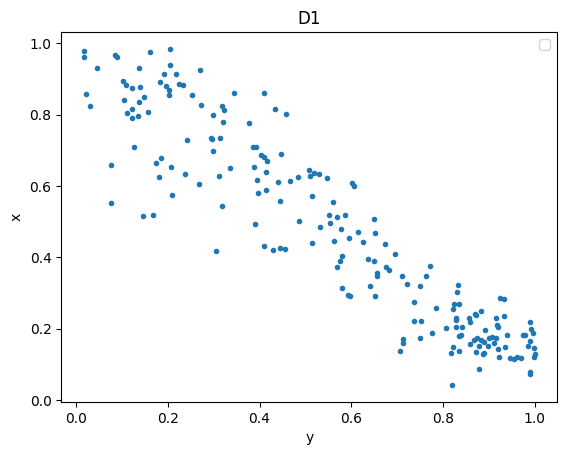

In [9]:
xs, ys = generate_D1(200,a,b,c,d, l, u)

Text(0, 0.5, 'f(x)')

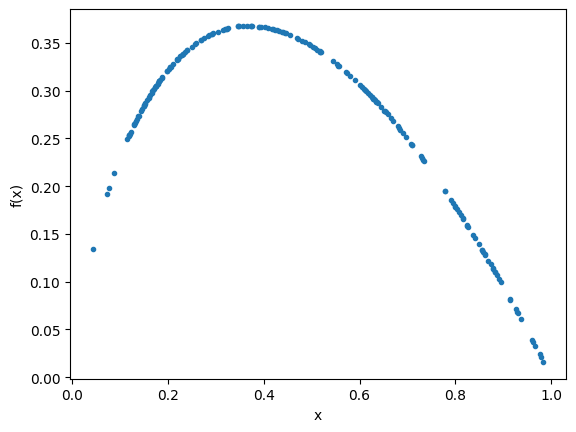

In [10]:
plt.plot(xs, func(xs), '.')
plt.xlabel('x')
plt.ylabel('f(x)')

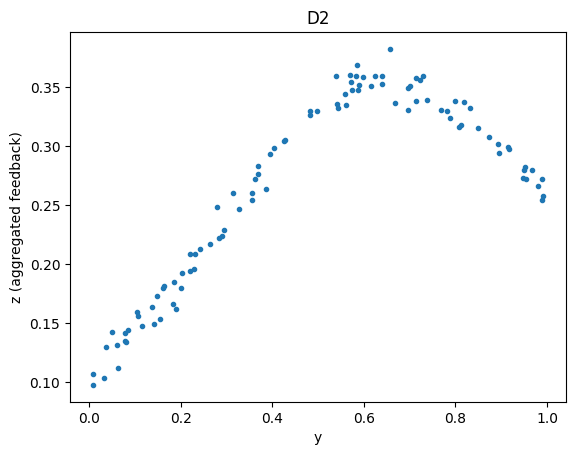

In [11]:
ys2, zs = generate_D2(100, a,b,c,d, l, u, sigma)

In [12]:
muz, sigmaz = zs.mean(), zs.std()
# muz, sigmaz = 0,1
zs = (zs - muz) / sigmaz

In [13]:
import sys
# sys.path.append("../deconditional-downscaling/")
sys.path.append("experiments/swiss_roll/")
from models import build_model, train_model, predict 
import yaml 
import torch

cdf_dir = 'experiments/swiss_roll/config/exact_cmp.yaml' 
# cdf_dir = 'exact_cmp.yaml' 

with open(cdf_dir, "r") as f:
    cfg = yaml.safe_load(f)

cfg['model'].update(individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys))
model = build_model(cfg['model'])

In [14]:
groundtruth_individuals = torch.tensor(np.linspace(1e-5,1-1e-5,100)).float()

cfg['training'].update(model=model,
                    individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys),
                    groundtruth_individuals=groundtruth_individuals,
                    groundtruth_bags_sizes=len(groundtruth_individuals),
                    groundtruth_targets=func(groundtruth_individuals).float(),
                    chunk_size=cfg['evaluation']['chunk_size_nll'],
                    device_idx='cpu',
                    dump_dir='result/'
                    )
train_model(cfg['training'])

In [15]:
predict_kwargs = {'name': cfg['model']['name'],
                'model': model.eval().cpu(),
                'individuals': groundtruth_individuals,
                'bags_sizes': func(groundtruth_individuals)}
individuals_posterior = predict(predict_kwargs)
individuals_posterior_mean = sigmaz * individuals_posterior.mean + muz
with torch.no_grad():
    stddev = sigmaz * individuals_posterior.stddev
    lower_bound = individuals_posterior_mean - 2 * stddev
    upper_bound = individuals_posterior_mean + 2 * stddev

In [16]:
individuals_posterior.sample()

tensor([-2.0388e-01, -4.1473e-01, -6.1154e-01, -7.8872e-01, -9.4216e-01,
        -1.0705e+00, -1.1512e+00, -1.2168e+00, -1.2339e+00, -1.2099e+00,
        -1.1584e+00, -1.0568e+00, -9.3625e-01, -7.7827e-01, -5.8715e-01,
        -3.8995e-01, -1.6637e-01,  5.7105e-02,  2.9162e-01,  5.2403e-01,
         7.4930e-01,  9.6585e-01,  1.1737e+00,  1.3452e+00,  1.5054e+00,
         1.6351e+00,  1.7534e+00,  1.8363e+00,  1.8892e+00,  1.9278e+00,
         1.9384e+00,  1.9348e+00,  1.9168e+00,  1.8954e+00,  1.8574e+00,
         1.8114e+00,  1.7787e+00,  1.7400e+00,  1.7119e+00,  1.6906e+00,
         1.6763e+00,  1.6773e+00,  1.6776e+00,  1.6968e+00,  1.7021e+00,
         1.7291e+00,  1.7486e+00,  1.7571e+00,  1.7603e+00,  1.7435e+00,
         1.7284e+00,  1.6753e+00,  1.6017e+00,  1.5155e+00,  1.4070e+00,
         1.2854e+00,  1.1389e+00,  9.8656e-01,  8.2984e-01,  6.6748e-01,
         5.0581e-01,  3.5441e-01,  2.1773e-01,  1.0428e-01,  1.2724e-03,
        -7.5330e-02, -1.2584e-01, -1.7419e-01, -2.0

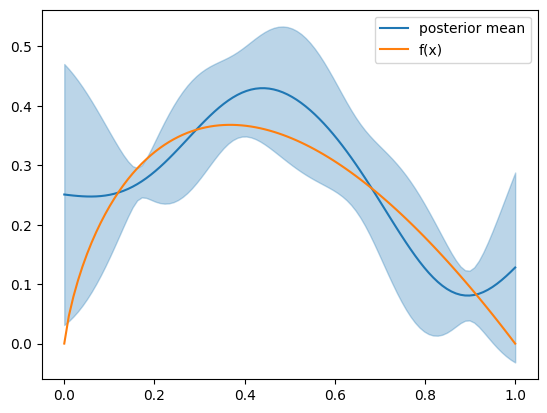

In [17]:
plt.plot(groundtruth_individuals, individuals_posterior_mean, label = 'posterior mean', color='C0')
plt.fill_between(groundtruth_individuals, lower_bound, upper_bound, alpha=0.3, color='C0')
# plt.plot(groundtruth_individuals, (conf[1]-conf[0]).detach().numpy(), label = '2 * posterior std')
plt.plot(groundtruth_individuals, func(groundtruth_individuals), label = 'f(x)', color='C1')
# plt.plot(xs, f(xs), '.', label = 'data points')
plt.legend()

In [18]:
groundtruth_individuals[np.argmin(func(groundtruth_individuals))]

tensor(1.0000)

In [19]:
groundtruth_individuals[np.argmin(individuals_posterior_mean)]

tensor(0.8990)

In [20]:
from BO import BayesOpt_UCB, BayesOpt_Random, PES, MES

# a = 0.1
# b = 4
# c = 2
# d = 0
# sigma = 0.01

def g_oracle(y, a=0.1,b=4,c=2,d=0, sigma=0.01):
    g_value = g(y, a,b,c,d)
    z_value = g_value + np.random.normal(0, sigma)
    return z_value

x_space = torch.tensor(np.linspace(1e-5,1-1e-5,100)).float() # np.linspace(1e-5,1-1e-5,100)
y_space = torch.tensor(np.linspace(1e-5,1-1e-5,100)).float() # np.linspace(1e-5,1-1e-5,100)
init_y_size = 3
num_round = 15
num_repeat = 5
random_seeds = np.random.uniform(0,100, num_repeat)

pos_best_dict = {}

xs = torch.from_numpy(xs).float()
ys = torch.from_numpy(ys).float()

  0%|          | 0/1 [00:00<?, ?it/s]

[0.09754165 0.76124448 0.24694303]


_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

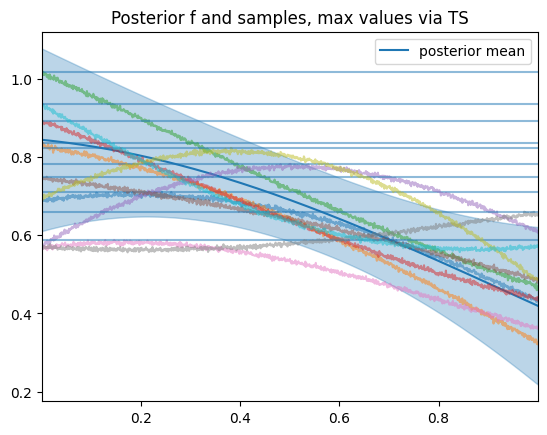

log_pdf_fm:  torch.Size([1, 128, 100, 1])


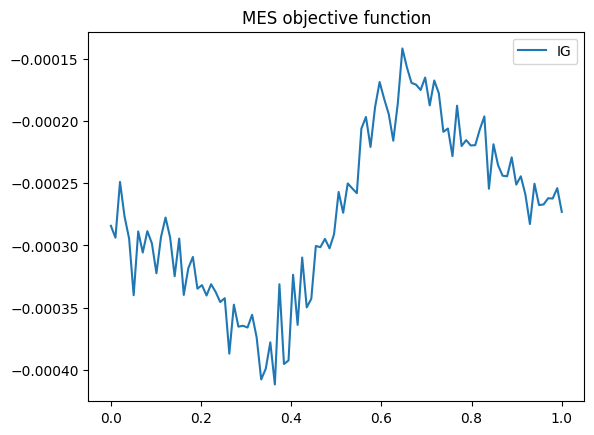

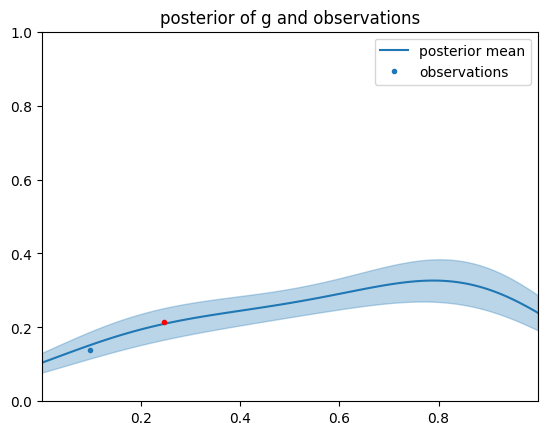

Iteration 1: Elapsed Time: 3.798682928085327 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

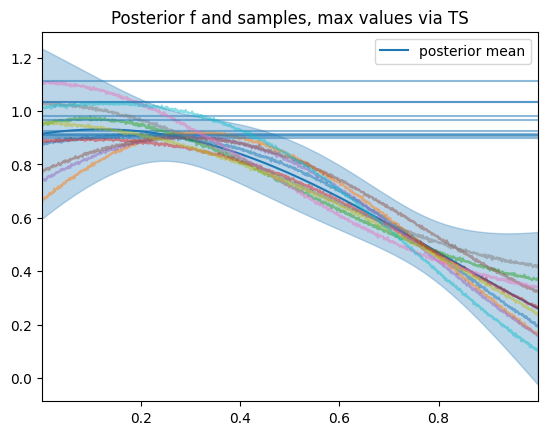

log_pdf_fm:  torch.Size([1, 128, 100, 1])


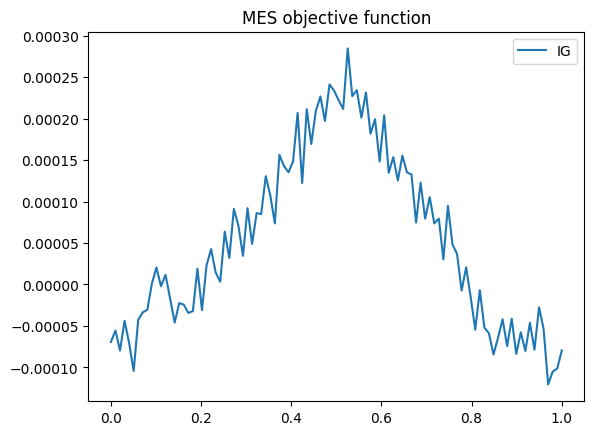

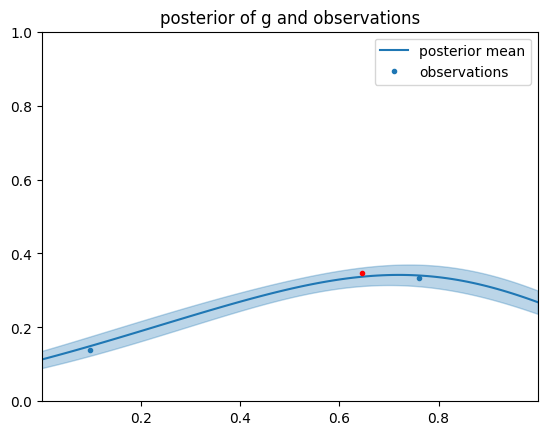

Iteration 2: Elapsed Time: 3.6729471683502197 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

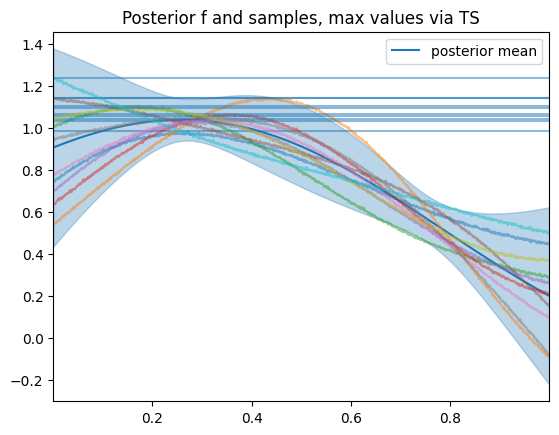

log_pdf_fm:  torch.Size([1, 128, 100, 1])


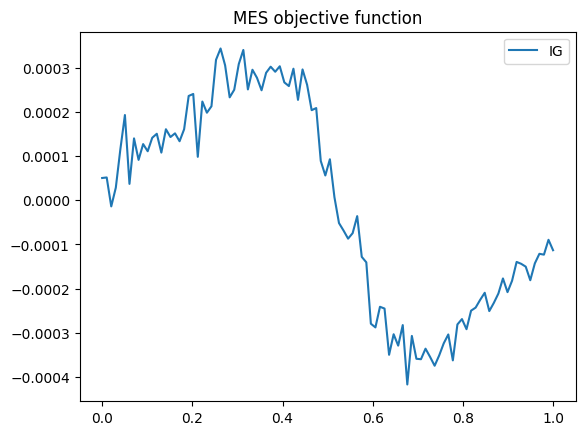

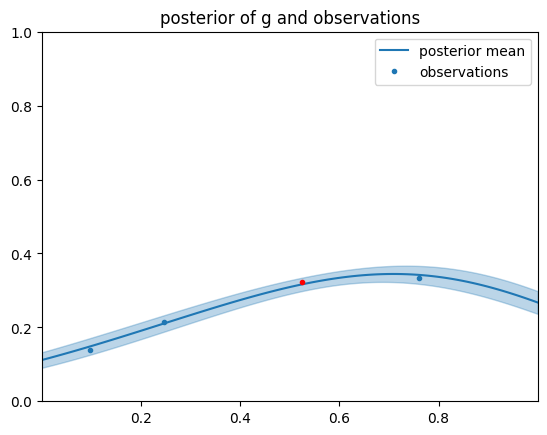

Iteration 3: Elapsed Time: 3.4561169147491455 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

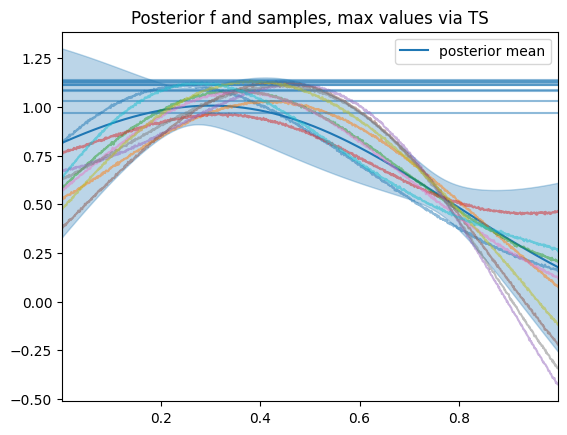

log_pdf_fm:  torch.Size([1, 128, 100, 1])


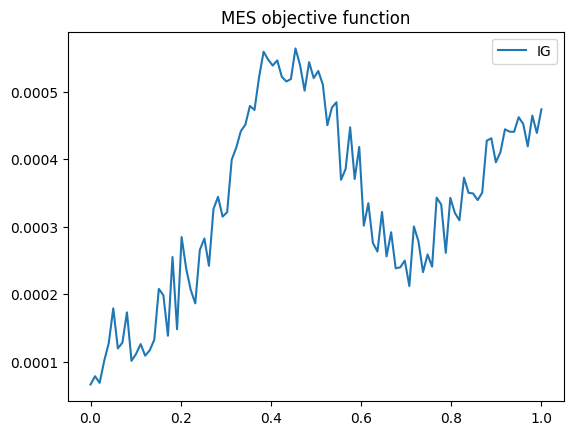

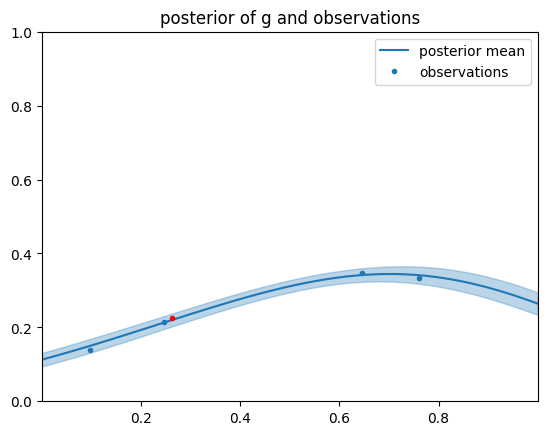

Iteration 4: Elapsed Time: 3.556337833404541 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

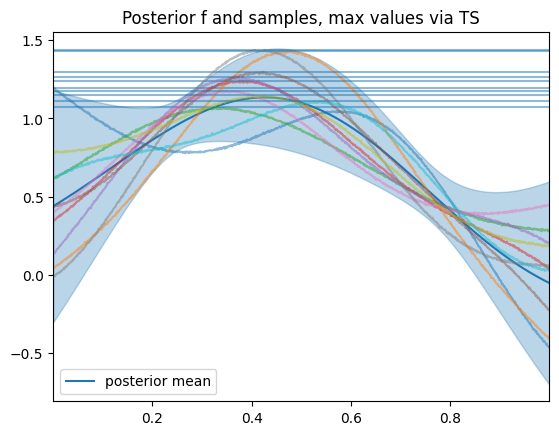

log_pdf_fm:  torch.Size([1, 128, 100, 1])


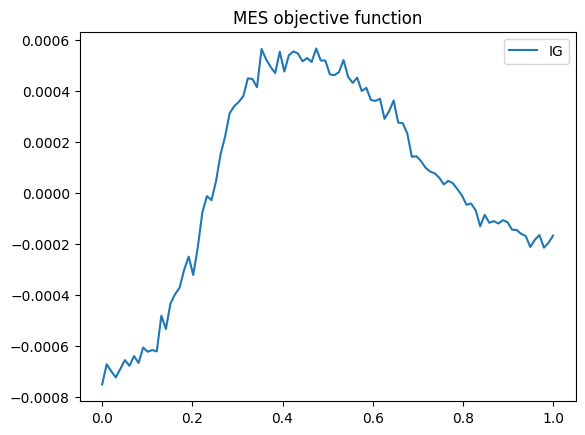

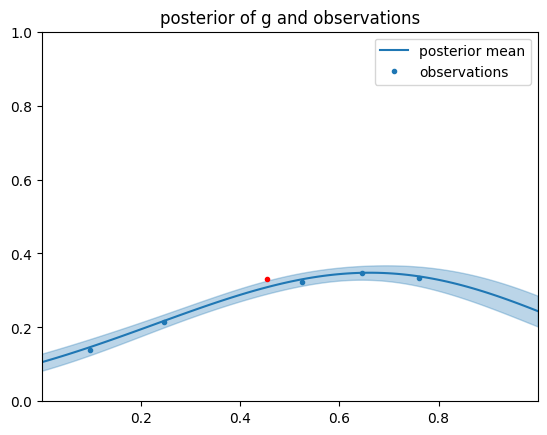

Iteration 5: Elapsed Time: 3.5956170558929443 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

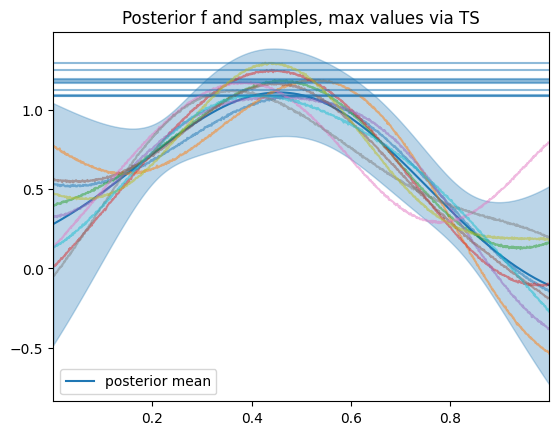

log_pdf_fm:  torch.Size([1, 128, 100, 1])


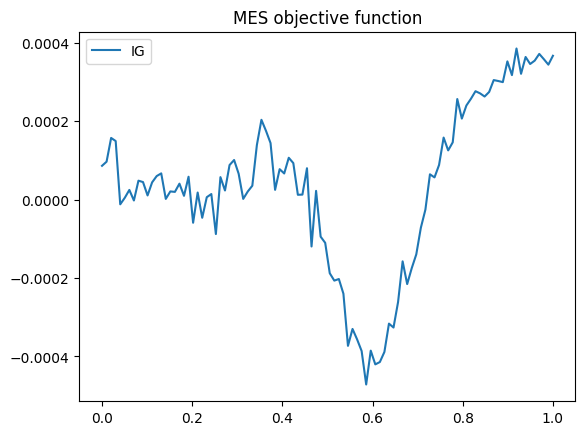

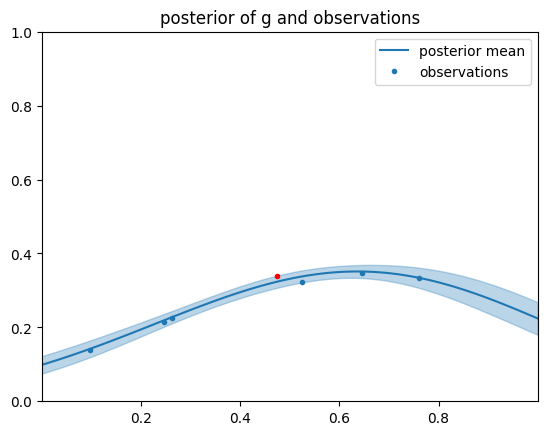

Iteration 6: Elapsed Time: 3.5657918453216553 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

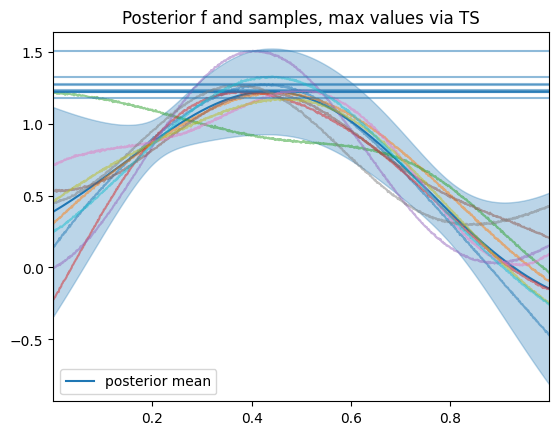

log_pdf_fm:  torch.Size([1, 128, 100, 1])


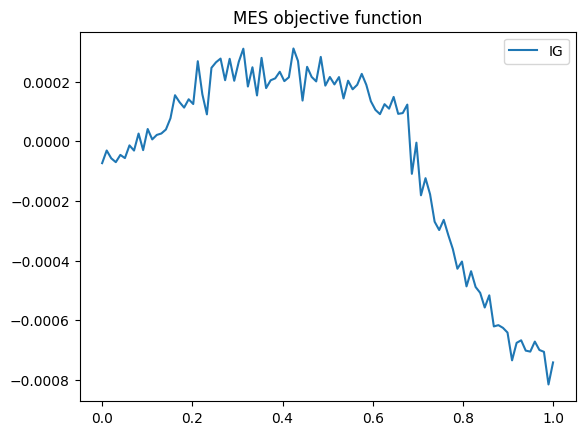

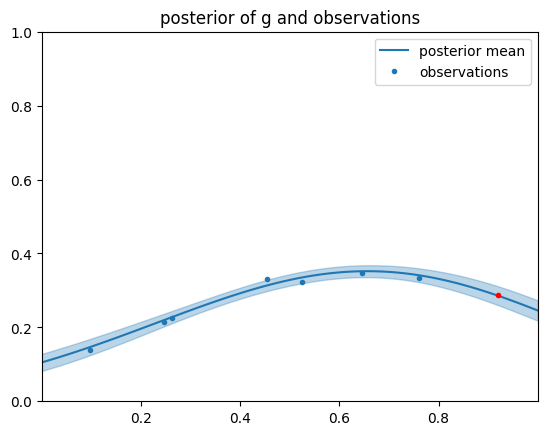

Iteration 7: Elapsed Time: 3.552125930786133 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

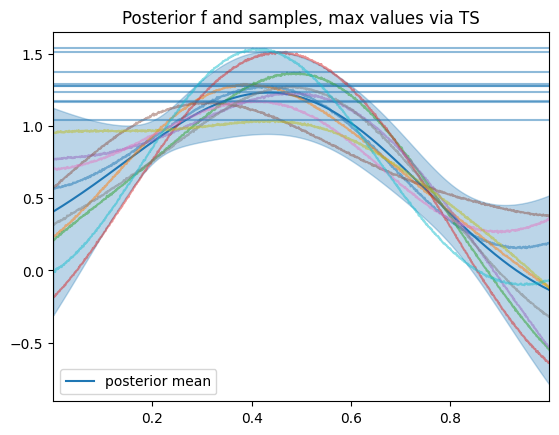

log_pdf_fm:  torch.Size([1, 128, 100, 1])


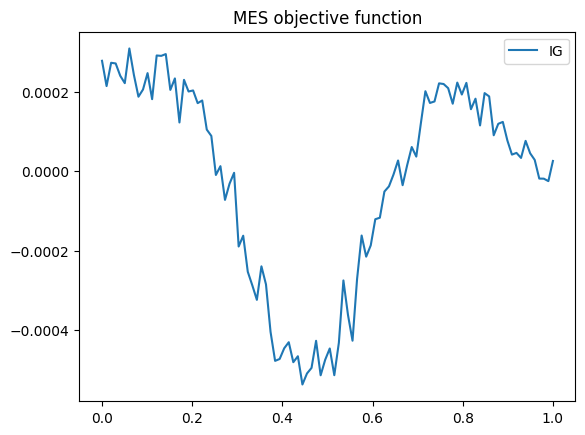

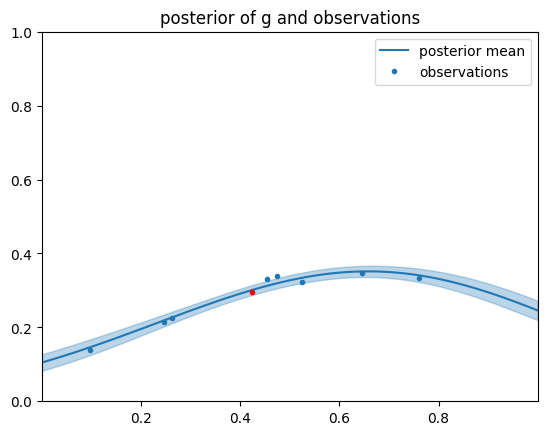

Iteration 8: Elapsed Time: 3.7289199829101562 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

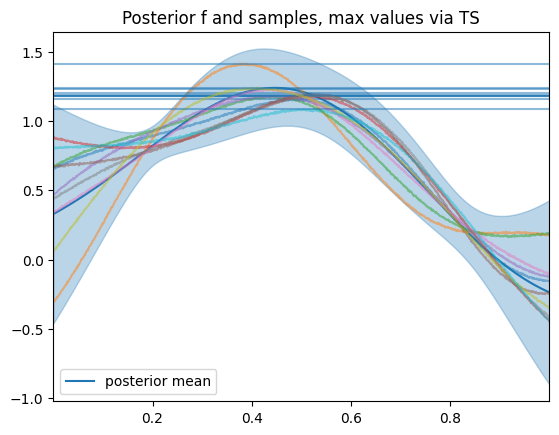

log_pdf_fm:  torch.Size([1, 128, 100, 1])


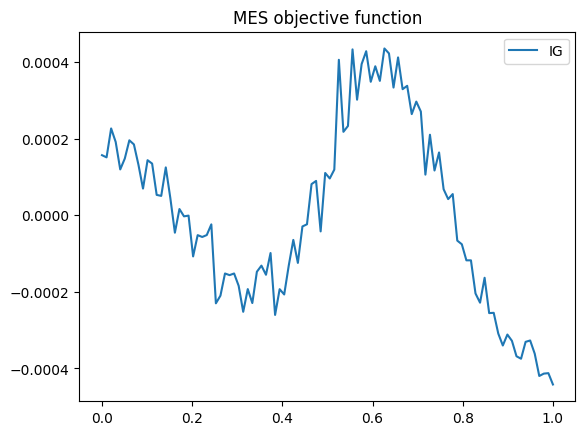

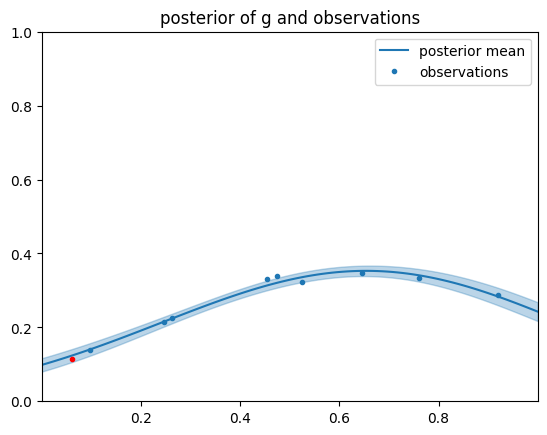

Iteration 9: Elapsed Time: 3.7480878829956055 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

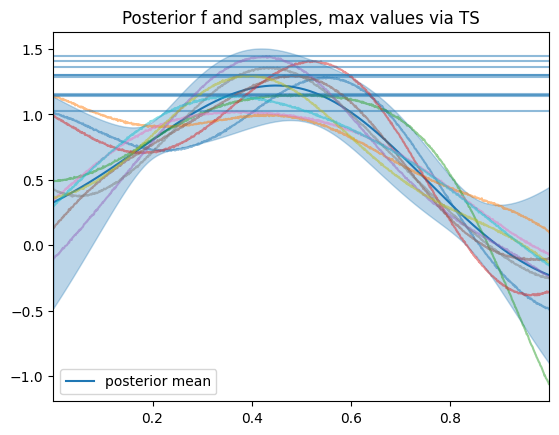

log_pdf_fm:  torch.Size([1, 128, 100, 1])


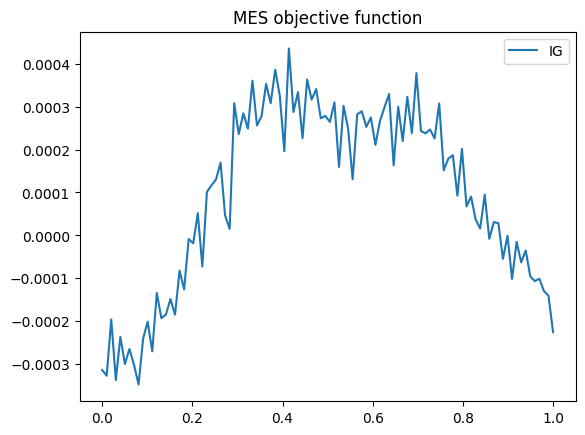

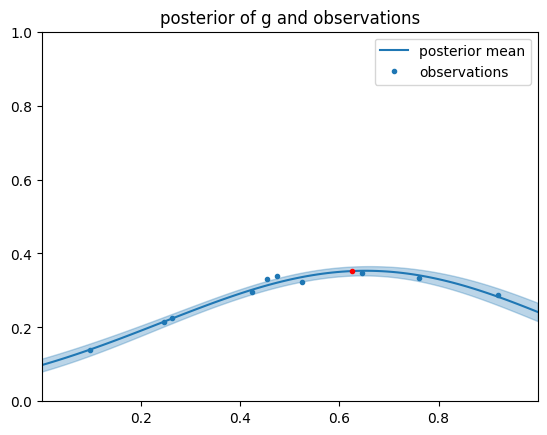

Iteration 10: Elapsed Time: 3.7002780437469482 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

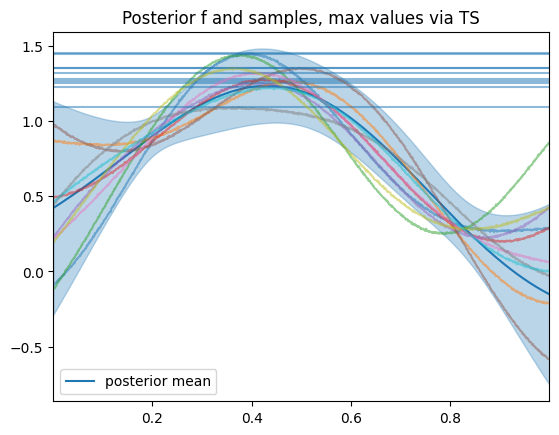

log_pdf_fm:  torch.Size([1, 128, 100, 1])


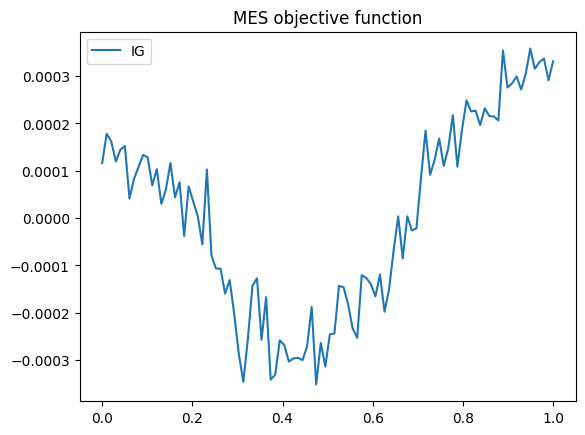

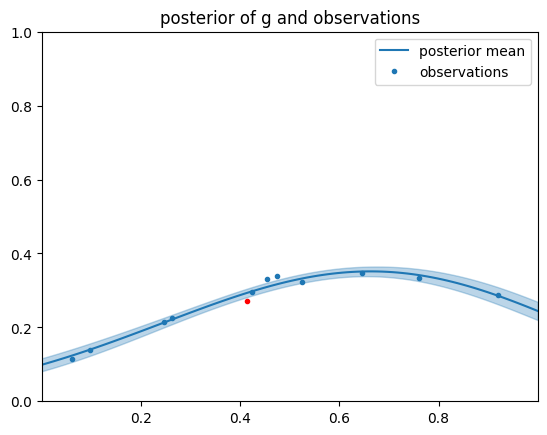

Iteration 11: Elapsed Time: 3.688601016998291 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

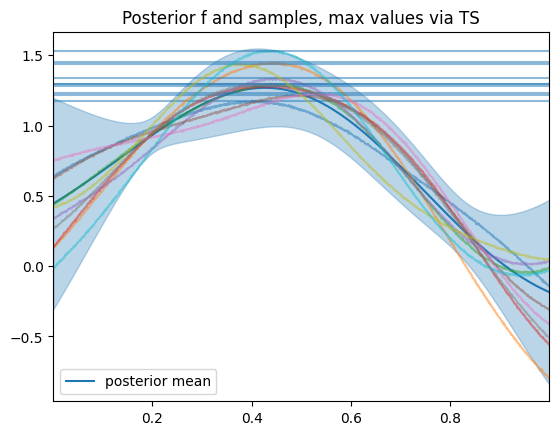

log_pdf_fm:  torch.Size([1, 128, 100, 1])


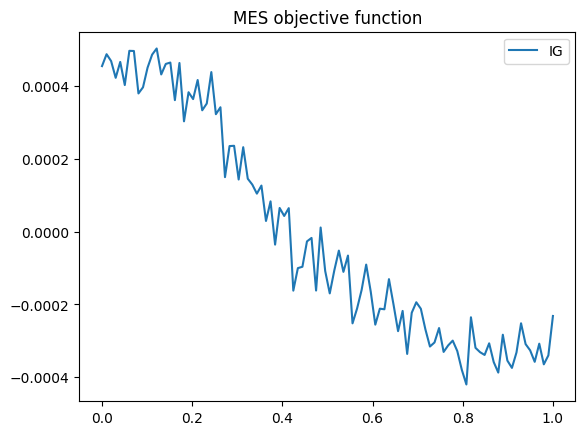

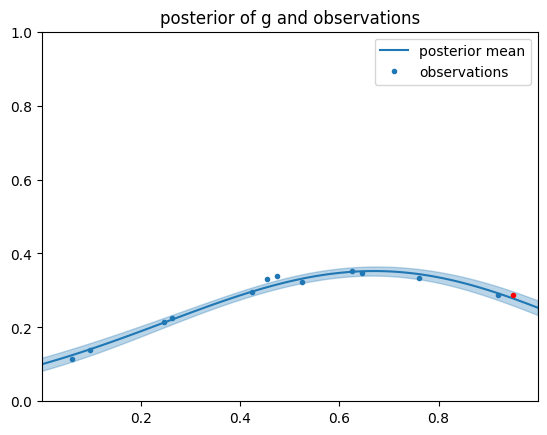

100%|██████████| 12/12 [00:43<00:00,  3.65s/it]

Iteration 12: Elapsed Time: 3.728238105773926 seconds



100%|██████████| 1/1 [00:44<00:00, 44.20s/it]


<Figure size 640x480 with 0 Axes>

In [22]:
# num_repeat = 1
agent_mes = MES(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp.yaml', dump_dir='result/mes/', random_seeds=random_seeds, maximize=True)
pos_best_dict['mes'] = agent_mes.simulation()

In [22]:
# agent_pes = PES(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/pes/',  y_min=-0.35, λ=0.01, num_opt_samples=10, random_seeds=random_seeds)
# pos_best_dict['pes'] = agent_pes.simulation()

In [23]:
# agent_ucb = BayesOpt_UCB(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/ucb/', random_seeds=random_seeds)
# pos_best_dict['ucb'] = agent_ucb.simulation()

In [24]:
agent_random = BayesOpt_Random(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/random/', random_seeds=random_seeds)
pos_best_dict['random']= agent_random.simulation()

  0%|          | 0/5 [00:00<?, ?it/s]

[0.84881071 0.17890234 0.05437213]


Iteration 1: Elapsed Time: 3.189707040786743 seconds


Iteration 2: Elapsed Time: 3.1355440616607666 seconds


Iteration 3: Elapsed Time: 3.288425922393799 seconds


Iteration 4: Elapsed Time: 3.1343469619750977 seconds


Iteration 5: Elapsed Time: 3.257627010345459 seconds


Iteration 6: Elapsed Time: 3.2029271125793457 seconds


Iteration 7: Elapsed Time: 3.1911211013793945 seconds


Iteration 8: Elapsed Time: 3.1940228939056396 seconds


Iteration 9: Elapsed Time: 3.2101099491119385 seconds


Iteration 10: Elapsed Time: 3.165687084197998 seconds


Iteration 11: Elapsed Time: 3.1859841346740723 seconds


100%|██████████| 12/12 [00:38<00:00,  3.20s/it]

Iteration 12: Elapsed Time: 3.212877035140991 seconds



 20%|██        | 1/5 [00:38<02:35, 38.77s/it]

[0.54688821 0.79789305 0.82039546]


Iteration 1: Elapsed Time: 3.220689058303833 seconds


Iteration 2: Elapsed Time: 3.1418700218200684 seconds


Iteration 3: Elapsed Time: 3.13977313041687 seconds


Iteration 4: Elapsed Time: 3.16853404045105 seconds


Iteration 5: Elapsed Time: 3.1762900352478027 seconds


Iteration 6: Elapsed Time: 3.1503169536590576 seconds


Iteration 7: Elapsed Time: 3.200615167617798 seconds


Iteration 8: Elapsed Time: 3.1935620307922363 seconds


Iteration 9: Elapsed Time: 3.1446969509124756 seconds


Iteration 10: Elapsed Time: 3.272240161895752 seconds


Iteration 11: Elapsed Time: 3.228464126586914 seconds


100%|██████████| 12/12 [00:38<00:00,  3.18s/it]

Iteration 12: Elapsed Time: 3.12434983253479 seconds



 40%|████      | 2/5 [01:17<01:55, 38.64s/it]

[0.73226259 0.56718766 0.30122786]


Iteration 1: Elapsed Time: 3.2205498218536377 seconds


Iteration 2: Elapsed Time: 3.119136095046997 seconds


Iteration 3: Elapsed Time: 3.1465039253234863 seconds


Iteration 4: Elapsed Time: 3.207862138748169 seconds


Iteration 5: Elapsed Time: 3.2213430404663086 seconds


Iteration 6: Elapsed Time: 3.1182360649108887 seconds


Iteration 7: Elapsed Time: 3.202279806137085 seconds


Iteration 8: Elapsed Time: 3.157238006591797 seconds


Iteration 9: Elapsed Time: 3.2175917625427246 seconds


Iteration 10: Elapsed Time: 3.1598000526428223 seconds


Iteration 11: Elapsed Time: 3.2253689765930176 seconds


100%|██████████| 12/12 [00:38<00:00,  3.18s/it]

Iteration 12: Elapsed Time: 3.1479344367980957 seconds



 60%|██████    | 3/5 [01:55<01:17, 38.58s/it]

[4.17023659e-01 7.20320077e-01 1.24372528e-04]


Iteration 1: Elapsed Time: 3.119654893875122 seconds


Iteration 2: Elapsed Time: 3.2774107456207275 seconds


Iteration 3: Elapsed Time: 3.0478901863098145 seconds


Iteration 4: Elapsed Time: 3.1475110054016113 seconds


Iteration 5: Elapsed Time: 26.966256141662598 seconds


Iteration 6: Elapsed Time: 3.5500869750976562 seconds


Iteration 7: Elapsed Time: 3.8651018142700195 seconds


Iteration 8: Elapsed Time: 3.809515953063965 seconds


Iteration 9: Elapsed Time: 3.6319217681884766 seconds


Iteration 10: Elapsed Time: 3.5170738697052 seconds


Iteration 11: Elapsed Time: 3.3202760219573975 seconds


100%|██████████| 12/12 [01:04<00:00,  5.37s/it]

Iteration 12: Elapsed Time: 3.226630687713623 seconds



 80%|████████  | 4/5 [03:00<00:48, 48.95s/it]

[0.6722751  0.48807863 0.82548865]


Iteration 1: Elapsed Time: 3.7622830867767334 seconds


Iteration 2: Elapsed Time: 3.3610596656799316 seconds


Iteration 3: Elapsed Time: 3.290313959121704 seconds


Iteration 4: Elapsed Time: 3.2626569271087646 seconds


Iteration 5: Elapsed Time: 3.2008121013641357 seconds


Iteration 6: Elapsed Time: 3.254685163497925 seconds


Iteration 7: Elapsed Time: 3.277930974960327 seconds


Iteration 8: Elapsed Time: 3.2475619316101074 seconds


Iteration 9: Elapsed Time: 3.2151260375976562 seconds


Iteration 10: Elapsed Time: 3.320690870285034 seconds


Iteration 11: Elapsed Time: 3.2873430252075195 seconds


100%|██████████| 12/12 [00:39<00:00,  3.32s/it]

Iteration 12: Elapsed Time: 3.305668830871582 seconds



100%|██████████| 5/5 [03:40<00:00, 44.17s/it]


<Figure size 640x480 with 0 Axes>

(array([4., 2., 1., 0., 2., 2., 2., 0., 1., 1.]),
 array([0.07762229, 0.16275404, 0.24788579, 0.33301756, 0.41814929,
        0.50328106, 0.58841282, 0.67354459, 0.75867629, 0.84380805,
        0.92893982]),
 <BarContainer object of 10 artists>)

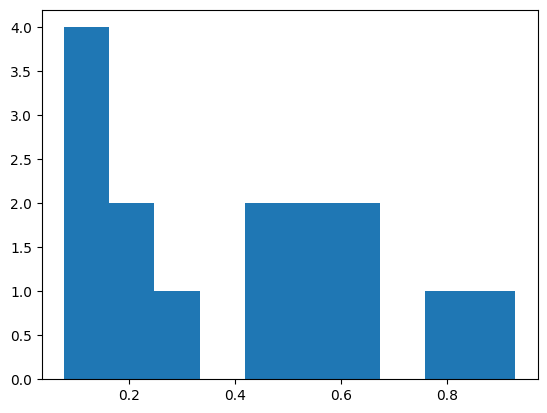

In [25]:
plt.hist(agent_random.y_recs)

In [26]:
def evalaution(pos_best_dict):
    # plt.plot(range(self.n), self.z_rewards[self.init_y_recs_size:], '.', label = 'z rewards')
    for name, pos_bests in pos_best_dict.items():
        opt = np.min(func(x_space.numpy()))
        regret_mean =np.abs(opt - pos_bests).mean(axis=0)
        print(regret_mean)
        regret_std =np.abs(opt - pos_bests).std(axis=0)
        # print(regret_mean)
        plt.plot(range(len(regret_mean)), regret_mean, label = name)
        plt.fill_between(range(len(regret_mean)), regret_mean - 2 * regret_std, regret_mean + 2 * regret_std, alpha = 0.3)
    plt.legend()
    plt.xlabel('Round')
    plt.ylabel('Regret')  

[4.2046286e-05 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00]
[2.1023143e-05 2.1023143e-05 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00]


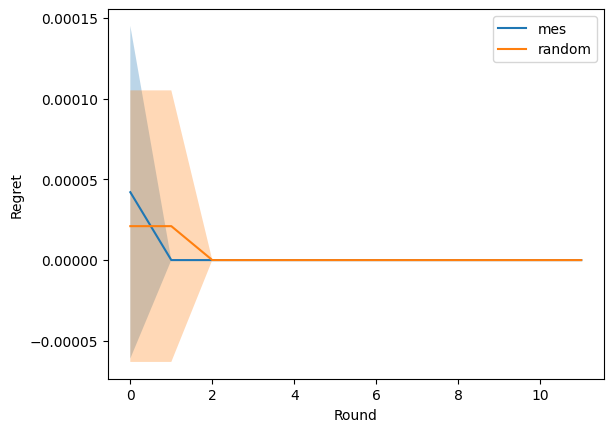

In [27]:
evalaution(pos_best_dict)

In [28]:
# np.save('pos-seed24.npy', pos_best_dict)